# TALENT Course 11
## Learning from Data: Bayesian Methods and Machine Learning
### York, UK, June 10-28, 2019 

# Bayesian neural networks
* The introduction part of this lecture, with accompanying lecture notes, are inspired by the chapter *"Learning as Inference"* in the excellent book [Information Theory, Inference, and Learning Algorithms](http://www.inference.org.uk/mackay/itila/) by David MacKay.
* The variational inference part of this lecture is adapted from the [blog entry](http://krasserm.github.io/2019/03/14/bayesian-neural-networks/) by Martin Krasser with some modifications. See also the following reference:
* [Weight Uncertainty in Neural Networks](https://arxiv.org/abs/1505.05424) (*Bayes by Backprop*). 

Additional references for Bayesian Neural Networks:
* [Tensorflow Probability](https://www.tensorflow.org/probability)
* [Edward](http://edwardlib.org/)
* [Keras](https://keras.io/) (for the implementation that is used in the example).

You will need `tensorflow` and `keras` for running this lecture notebook and the accompanying exercise. In this directory, please run

    conda deactivate
	conda env create

which reads the environment.yml file and creates the virtual environment `talent-env-ml`. It can be activated:

    conda activate talent-env-ml


## Basic neural network

We will consider neurons with a vector of $I$ input signals $\mathbf{x} = \left\{ x_i \right\}_{i=1}^I$, and an output signal $y(a)$, which is a (often non-linear) function of the *activation*
$$
a = \sum_i w_i x_i,
$$
where $\mathbf{w} = \left\{ w_i \right\}_{i=1}^I$ are the weights of the neuron. The sum runs from either 1 to $I$, or from 0 to $I$ if there is also a bias ($b \equiv w_0$).

The training of the network implies feeding it with training data and finding the sets of weights and biases that minimizes a loss function that has been selected for that particular problem.

Consider, e.g., a classification problem where the single output $y$ of the final network layer is a real number $\in [0,1]$ that indicates the probability for input $\mathbf{x}$ belonging to either class $t=1$ or $t=0$:
$$
\begin{align}
p(t=1 | w,x) &= y \\
p(t=0 | w,x) &= 1-y,
\end{align}
$$
where we have simplified the notation, not using boldface anymore for the arrays $w$ and $x$.

A simple neural network classifier can be trained by minimizing the loss function
$$
M(w) = G(w) +  \alpha E_W(w),
$$
made up of an error function
$$
G(w) = -\sum_n \left[ t^{(n)} \log ( y(x^{(n)},w)) + (1 - t^{(n)}) \log (1 - y(x^{(n)},w)) \right],
$$
where $t^{(n)}$ is the training data, and the regularizer
$$
E_W(w) = \frac{1}{2} \sum_i w_i^2,
$$
that is designed to avoid overfitting.

The error function can be interpreted as minus the log likelihood
$$
p(D|w) = \exp\left[ - G(w) \right].
$$
Similarly the regularizer can be interpreted in terms of a log prior probability distribution over the parameters
$$
p(w | \alpha) = \frac{1}{Z_W(\alpha)} \exp \left[ -\alpha E_W \right].
$$
If $E_W$ is quadratic as given above, then the corresponding prior distribution is a Gaussian with variance $\sigma_W^2 = 1/\alpha$ and $1/Z_W = (\alpha/2\pi)^{K/2}$, where $K$ is the number of parameters in $w$.

The objective function $M(w)$ then corresponds to the inference of the parameters $w$ given the data
$$
p(w | D, \alpha) = \frac{p(D|w) p(w|\alpha)}{p(D|\alpha)} = \frac{1}{Z_M} \exp [ -M(w) ].
$$

The network parameters $w$ that are found by minimizing $M(w)$ can be interpreted as the (locally) most probable parameter vector $w^*$. We show the different probability distributions for a typical training sequence in the following figure (reproduced from [Information Theory, Inference, and Learning Algorithms](http://www.inference.org.uk/mackay/itila/) by David MacKay)

![MacKay Fig. 41.1](fig/MacKay_41_1.png)

Instead, we will use the Bayesian approach and consider the information that is contained in the probability distribution. A Bayesian prediction of a new datum $t^{(n+1)}$ involves *marginalizing* over the parameters
$$
p(t^{(n+1)} | x^{(n+1)}, D, \alpha) = \int d^K w p(t^{(n+1)} | x^{(n+1)}, w, \alpha) p(w|D,\alpha).
$$
We show an example of such inference (with the point estimate $w^*$ and the Bayesian approach) in the follwoing figure (again from MacKay)

![MacKay Fig. 41.2](fig/MacKay_41_2.png)

But how shall we compute the marginalization integral for real network with thousands of parameters?

In short, there are three different approaches:
1. "exact" methods by MCMC sampling (they are exact as the number of samples $\rightarrow \infty$);
2. deterministic approximate methods, for example using Gaussian approximations with the Laplace method;
3. variational methods.

The first two are discussed in MacKay's book, while we will focus on a variational method in the following regression problem.

## Variational inference for Bayesian neural networks

This article demonstrates how to implement and train a Bayesian neural network with Keras following the approach described in [Weight Uncertainty in Neural Networks](https://arxiv.org/abs/1505.05424) (*Bayes by Backprop*). The implementation is kept simple for illustration purposes and uses Keras 2.2.4 and Tensorflow 1.12.0. For more advanced implementations of Bayesian methods for neural networks consider using [Tensorflow Probability](https://www.tensorflow.org/probability), for example.

Bayesian neural networks differ from plain neural networks in that their weights are assigned a probability distribution instead of a single value or point estimate. These probability distributions describe the uncertainty in weights and can be used to estimate uncertainty in predictions. Training a Bayesian neural network via variational inference learns the parameters of these distributions instead of the weights directly.

### Probabilistic model

A neural network can be viewed as probabilistic model $p(y \lvert \mathbf{x},\mathbf{w})$. For classification, $y$ is a set of classes and $p(y \lvert \mathbf{x},\mathbf{w})$ is a categorical distribution. For regression, $y$ is a continuous variable and $p(y \lvert \mathbf{x},\mathbf{w})$ is a Gaussian distribution. 

Given a training dataset $\mathcal{D} = \left\{\mathbf{x}^{(i)}, y^{(i)}\right\}$ we can construct the likelihood function $p(\mathcal{D} \lvert \mathbf{w}) = \prod_i p(y^{(i)} \lvert \mathbf{x}^{(i)}, \mathbf{w})$ which is a function of parameters $\mathbf{w}$. Maximizing the likelihood function gives the maximimum likelihood estimate (MLE) of $\mathbf{w}$. The usual optimization objective during training is the negative log likelihood. For a categorical distribution this is the *cross entropy* error function, for a Gaussian distribution this is proportional to the *sum of squares* error function. MLE can lead to severe overfitting though.

Multiplying the likelihood with a prior distribution $p(\mathbf{w})$ is, by Bayes theorem, proportional to the posterior distribution $p(\mathbf{w} \lvert \mathcal{D}) \propto p(\mathcal{D} \lvert \mathbf{w}) p(\mathbf{w})$. Maximizing $p(\mathcal{D} \lvert \mathbf{w}) p(\mathbf{w})$ gives the maximum a posteriori (MAP) estimate of $\mathbf{w}$. Computing the MAP estimate has a regularizing effect and can prevent overfitting. The optimization objectives here are the same as for MLE plus a regularization term coming from the log prior.

Both MLE and MAP give point estimates of parameters. If we instead had a full posterior distribution over parameters we could make predictions that take weight uncertainty into account. This is covered by the posterior predictive distribution $p(y \lvert \mathbf{x},\mathcal{D}) = \int p(y \lvert \mathbf{x}, \mathbf{w}) p(\mathbf{w} \lvert \mathcal{D}) d\mathbf{w}$ in which the parameters have been marginalized out. This is equivalent to averaging predictions from an ensemble of neural networks weighted by the posterior probabilities of their parameters $\mathbf{w}$. 

### Variational inference

Unfortunately, an analytical solution for the posterior $p(\mathbf{w} \lvert \mathcal{D})$ in neural networks is intractable. We therefore have to approximate the true posterior with a variational distribution $q(\mathbf{w} \lvert \boldsymbol{\theta})$ of known functional form whose parameters we want to estimate. This can be done by minimizing the [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between $q(\mathbf{w} \lvert \boldsymbol{\theta})$ and the true posterior $p(\mathbf{w} \lvert \mathcal{D})$  w.r.t. $\boldsymbol{\theta}$. 

The Kullback-Leibler (KL) Divergence is a numeric measure of the difference between two distributions. For two probability distributions $Q$ and $P$, the KL divergence in a continuous case, 
$$
\mathrm{KL}(Q||P) = \int_{-\infty}^\infty dx q(x) \log \frac{q(x)}{p(x)} dx \equiv \mathbb{E}_{q(x)} \left[ \log q(x) - \log p(x) \right] 
$$
As we can see, the KL divergence calculates the expected log differences in between two distributions with respect to distribution Q.

It can be shown that the corresponding optimization objective or cost function can be written as

$$
\mathcal{F}(\mathcal{D},\boldsymbol{\theta}) = 
\mathrm{KL}(q(\mathbf{w} \lvert \boldsymbol{\theta}) \mid\mid p(\mathbf{w})) -
\mathbb{E}_{q(\mathbf{w} \lvert \boldsymbol{\theta})} \log p(\mathcal{D} \lvert \mathbf{w})
\tag{1}
$$

This is known as the *variational free energy*. The first term is the Kullback-Leibler divergence between the variational distribution $q(\mathbf{w} \lvert \boldsymbol{\theta})$ and the prior $p(\mathbf{w})$ and is called the *complexity cost*. The second term is the expected value of the likelihood w.r.t. the variational distribution and is called the *likelihood cost*. By re-arranging the KL term, the cost function can also be written as 

$$
\mathcal{F}(\mathcal{D},\boldsymbol{\theta}) = 
\mathbb{E}_{q(\mathbf{w} \lvert \boldsymbol{\theta})} \log q(\mathbf{w} \lvert \boldsymbol{\theta}) -
\mathbb{E}_{q(\mathbf{w} \lvert \boldsymbol{\theta})} \log p(\mathbf{w}) -
\mathbb{E}_{q(\mathbf{w} \lvert \boldsymbol{\theta})} \log p(\mathcal{D} \lvert \mathbf{w})
\tag{2}
$$

We realize that minimization of the variational free energy is obtained by finding the parameters $\theta$ that
* maximizes

$$
\mathbb{E}_{q(\mathbf{w} \lvert \boldsymbol{\theta})} \log \big( p(\mathbf{w}) p(\mathcal{D} \lvert \mathbf{w}) \big) = 
\mathbb{E}_{q(\mathbf{w} \lvert \boldsymbol{\theta})} \log p(\mathbf{w, \mathcal{D}}), 
$$

  which encourages weights that fit data well.
* and maximizes

$$
- \mathbb{E}_{q(\mathbf{w} \lvert \boldsymbol{\theta})} \log q(\mathbf{w} \lvert \boldsymbol{\theta}) = -\int d \mathbf{w} q(\mathbf{w} \lvert \boldsymbol{\theta}) \log q(\mathbf{w} \lvert \boldsymbol{\theta}),
$$

  which we recognize as the entropy.

We see that all three terms in equation (2) are expectations w.r.t. the variational distribution $q(\mathbf{w} \lvert \boldsymbol{\theta})$. The cost function can therefore be approximated by drawing [Monte Carlo](https://en.wikipedia.org/wiki/Monte_Carlo_method) samples $\mathbf{w}^{(i)}$ from $q(\mathbf{w} \lvert \boldsymbol{\theta})$.

$$
\mathcal{F}(\mathcal{D},\boldsymbol{\theta}) \approx {1 \over N} \sum_{i=1}^N \left[
\log q(\mathbf{w}^{(i)} \lvert \boldsymbol{\theta}) -
\log p(\mathbf{w}^{(i)}) -
\log p(\mathcal{D} \lvert \mathbf{w}^{(i)})\right]
\tag{3}
$$

In the following example, we'll use a Gaussian distribution for the variational posterior, parameterized by $\boldsymbol{\theta} = (\boldsymbol{\mu}, \boldsymbol{\sigma})$ where $\boldsymbol{\mu}$ is the mean vector of the distribution and $\boldsymbol{\sigma}$ the standard deviation vector. The elements of $\boldsymbol{\sigma}$ are the elements of a diagonal covariance matrix which means that weights are assumed to be uncorrelated. Instead of parameterizing the neural network with weights $\mathbf{w}$ directly we parameterize it with $\boldsymbol{\mu}$ and $\boldsymbol{\sigma}$ and therefore double the number of parameters compared to a plain neural network. 

### Network training

A training iteration consists of a forward-pass and and backward-pass. During a forward pass a single sample is drawn from the variational posterior distribution. It is used to evaluate the approximate cost function defined by equation (3). The first two terms of the cost function are data-independent and can be evaluated layer-wise, the last term is data-dependent and is evaluated at the end of the forward-pass. During a backward-pass, gradients of $\boldsymbol{\mu}$ and $\boldsymbol{\sigma}$ are calculated via backpropagation so that their values can be updated by an optimizer.

Since a forward pass involves a stochastic sampling step we have to apply the so-called *re-parameterization trick* for backpropagation to work. The trick is to sample from a parameter-free distribution and then transform the sampled $\boldsymbol{\epsilon}$ with a deterministic function $t(\boldsymbol{\mu}, \boldsymbol{\sigma}, \boldsymbol{\epsilon})$ for which a gradient can be defined. Here, we choose $\boldsymbol{\epsilon}$ to be drawn from a standard normal distribution i.e. $\boldsymbol{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ and the function $t$ is taken to be $t(\boldsymbol{\mu}, \boldsymbol{\sigma}, \boldsymbol{\epsilon}) = \boldsymbol{\mu} + \boldsymbol{\sigma} \odot \boldsymbol{\epsilon}$, i.e., it shifts the sample by mean $\boldsymbol{\mu}$ and scales it with $\boldsymbol{\sigma}$ where $\odot$ is element-wise multiplication.

For numerical stability we will parameterize the network with $\boldsymbol{\rho}$ instead of $\boldsymbol{\sigma}$ directly and transform $\boldsymbol{\rho}$ with the softplus function to obtain $\boldsymbol{\sigma} = \log(1 + \exp(\boldsymbol{\rho}))$. This ensures that $\boldsymbol{\sigma}$ is always positive. As prior, a scale mixture of two Gaussians is used $p(\mathbf{w}) = \pi \mathcal{N}(\mathbf{w} \lvert 0,\sigma_1^2) + (1 - \pi) \mathcal{N}(\mathbf{w} \lvert 0,\sigma_2^2)$ where $\sigma_1$, $\sigma_2$ and $\pi$ are shared parameters. Their values are learned during training (which is in contrast to the paper where a fixed prior is used). 

### Uncertainty characterization

Uncertainty in predictions that arise from the uncertainty in weights is called [epistemic uncertainty](https://en.wikipedia.org/wiki/Uncertainty_quantification). This kind of uncertainty can be reduced if we get more data. Consequently,  epistemic uncertainty is higher in regions of no or little training data and lower in regions of more training data. Epistemic uncertainty is covered by the variational posterior distribution. Uncertainty coming from the inherent noise in training data is an example of [aleatoric uncertainty](https://en.wikipedia.org/wiki/Uncertainty_quantification). It cannot be reduced if we get more data. Aleatoric uncertainty is covered by the probability distribution used to define the likelihood function. 

### Implementation example

Variational inference of neural network parameters is now demonstrated on a simple regression problem. We therefore use a Gaussian distribution for $p(y \lvert \mathbf{x},\mathbf{w})$. The training dataset consists of a few noisy samples `x_train`, `y_train` drawn from the `true_function` function with Gaussian noise.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns; 
sns.set('talk')

# make your loops show a smart progress meter - just wrap any iterable with tqdm(iterable)
import tqdm

In [2]:
x_train_min = -3
x_train_max = 3

def true_function(x, k=1., slope=1.):
    """
    Linear plus cosine function with adjustable slope and wave number.
    """
    return slope * x + np.cos(k*x)

def build_toy_dataset(N=20, noise_std=.1, k=1., slope=1.):
    """
    Generate toy data arrays with N points and added Gaussian noise with
    standard deviation noise_std.
    """
    #np.random.seed(47)
    x = np.random.uniform(x_train_min, x_train_max, size=N)
    y = true_function(x, k, slope) \
        + np.random.normal(0, noise_std * abs(x), size=N)
    x = x.astype(np.float32).reshape((N, 1))
    y = y.astype(np.float32)
    return x, y

In [3]:
train_size = 20       # number of data ponts
k = 1.0      # scale wavelength
slope = 0.2  # linear term: slope*x
noise = 0.1

x_train, y_train = build_toy_dataset(train_size, noise_std=noise, k=k, slope=slope)

In [4]:
# Produce an array with true function evaluations
x_linspace = np.linspace(x_train_min, x_train_max, 100).reshape(-1, 1)
y_true = true_function(x_linspace, k=k, slope=slope)

The noise in training data gives rise to aleatoric uncertainty. To cover epistemic uncertainty we implement the variational inference logic in a custom `DenseVariational` Keras layer. The learnable parameters of the mixture prior, $\sigma_1$ $\sigma_2$ and $\pi$, are shared across layers. The complexity cost (`kl_loss`) is computed layer-wise and added to the total loss with the `add_loss` method. Implementations of `build` and `call` directly follow the equations defined above. 

Note that many of these features are now available in the [Tensorflow Probability](https://www.tensorflow.org/probability) Python library. It might be instructive, however, to see how the DenseVariational Layer is constructed explicitly.

In [5]:
from keras import backend as K
from keras import activations, initializers
from keras.layers import Layer

import tensorflow as tf

def mixture_prior_params(sigma_1, sigma_2, pi, return_sigma=False):
    params = K.variable([sigma_1, sigma_2, pi], name='mixture_prior_params')
    sigma = np.sqrt(pi * sigma_1 ** 2 + (1 - pi) * sigma_2 ** 2)
    return params, sigma

def log_mixture_prior_prob(w):
    comp_1_dist = tf.distributions.Normal(0.0, prior_params[0])
    comp_2_dist = tf.distributions.Normal(0.0, prior_params[1])
    comp_1_weight = prior_params[2]    
    return K.log(comp_1_weight * comp_1_dist.prob(w) + (1 - comp_1_weight) * comp_2_dist.prob(w))    

# Mixture prior parameters shared across DenseVariational layer instances
prior_params, prior_sigma = mixture_prior_params(sigma_1=1.0, sigma_2=0.1, pi=0.2)

class DenseVariational(Layer):
    def __init__(self, output_dim, kl_loss_weight, activation=None, **kwargs):
        self.output_dim = output_dim
        self.kl_loss_weight = kl_loss_weight
        self.activation = activations.get(activation)
        super().__init__(**kwargs)

    def build(self, input_shape):  
        self._trainable_weights.append(prior_params) 

        self.kernel_mu = self.add_weight(name='kernel_mu', 
                                         shape=(input_shape[1], self.output_dim),
                                         initializer=initializers.normal(stddev=prior_sigma),
                                         trainable=True)
        self.bias_mu = self.add_weight(name='bias_mu', 
                                       shape=(self.output_dim,),
                                       initializer=initializers.normal(stddev=prior_sigma),
                                       trainable=True)
        self.kernel_rho = self.add_weight(name='kernel_rho', 
                                          shape=(input_shape[1], self.output_dim),
                                          initializer=initializers.constant(0.0),
                                          trainable=True)
        self.bias_rho = self.add_weight(name='bias_rho', 
                                        shape=(self.output_dim,),
                                        initializer=initializers.constant(0.0),
                                        trainable=True)
        super().build(input_shape)

    def call(self, x):
        kernel_sigma = tf.math.softplus(self.kernel_rho)
        kernel = self.kernel_mu + kernel_sigma * tf.random.normal(self.kernel_mu.shape)

        bias_sigma = tf.math.softplus(self.bias_rho)
        bias = self.bias_mu + bias_sigma * tf.random.normal(self.bias_mu.shape)
                
        self.add_loss(self.kl_loss(kernel, self.kernel_mu, kernel_sigma) + 
                      self.kl_loss(bias, self.bias_mu, bias_sigma))
        
        return self.activation(K.dot(x, kernel) + bias)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)
    
    def kl_loss(self, w, mu, sigma):
        variational_dist = tf.distributions.Normal(mu, sigma)
        return kl_loss_weight * K.sum(variational_dist.log_prob(w) - log_mixture_prior_prob(w))

Using TensorFlow backend.


In [7]:
from keras.layers import Input
from keras.models import Model

batch_size = train_size
num_batches = train_size / batch_size
kl_loss_weight = 1.0 / num_batches

x_in = Input(shape=(1,))
x = DenseVariational(20, kl_loss_weight=kl_loss_weight, activation='relu')(x_in)
x = DenseVariational(20, kl_loss_weight=kl_loss_weight, activation='relu')(x)
x = DenseVariational(1, kl_loss_weight=kl_loss_weight)(x)

model = Model(x_in, x)

Our model is a neural network with two `DenseVariational` hidden layers, each having 20 units, and one `DenseVariational` output layer with one unit. Instead of modeling a full probability distribution $p(y \lvert \mathbf{x},\mathbf{w})$ as output the network simply outputs the mean of the corresponding Gaussian distribution. In other words, we do not model aleatoric uncertainty here and assume it is known. We only model epistemic uncertainty via the `DenseVariational` layers.

Since the training dataset has very few data points we train the network with all of them per epoch so that the number of batches per epoch is 1. For other configurations, the complexity cost (`kl_loss`) must be weighted by $1/M$ as described in section 3.4 of the [paper](https://arxiv.org/abs/1505.05424) where $M$ is the number of mini-batches per epoch.

The network can now be trained with a Gaussian negative log likelihood function (`neg_log_likelihood`) as loss function assuming a fixed standard deviation (`noise`). This corresponds to the *likelihood cost*, the last term in equation $3$. 

In [9]:
from keras import callbacks, optimizers

def neg_log_likelihood(y_true, y_pred, sigma=noise):
    dist = tf.distributions.Normal(loc=y_pred, scale=sigma)
    return K.sum(-dist.log_prob(y_true))

model.compile(loss=neg_log_likelihood, optimizer=optimizers.Adam(lr=0.03), metrics=['mse'])

In [10]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=5000, verbose=0);

W0625 22:17:44.618273 4618782144 deprecation_wrapper.py:119] From /Applications/anaconda3/envs/talent-env-ml3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



In [11]:
X_test = np.linspace(-5, 5, 1000).reshape(-1, 1)
y_true_test = true_function(X_test, k=k, slope=slope)
y_pred_list = []

for i in tqdm.tqdm(range(500)):
    y_pred = model.predict(X_test)
    y_pred_list.append(y_pred)
    
y_preds = np.concatenate(y_pred_list, axis=1)

100%|██████████| 500/500 [00:05<00:00, 97.92it/s] 


When calling `model.predict` we draw a random sample from the variational posterior distribution and use it to compute the output value of the network. This is equivalent to obtaining the output from a single member of a hypothetical ensemble of neural networks. Drawing 500 samples means that we get predictions from 500 ensemble members. From these predictions we can compute statistics such as the mean and standard deviation. In our example, the standard deviation is a measure of epistemic uncertainty.

In [12]:
y_mean = np.mean(y_preds, axis=1)
y_sigma = np.std(y_preds, axis=1)

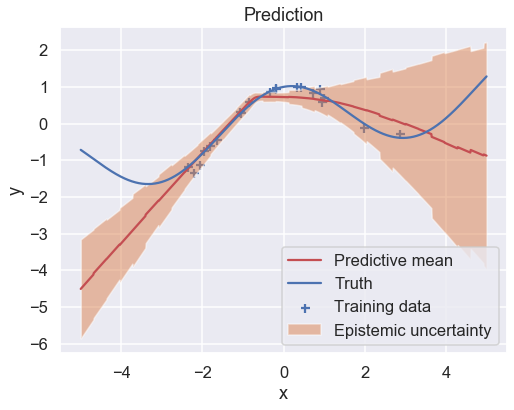

In [13]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(X_test, y_mean, 'r-', label='Predictive mean');
ax.scatter(x_train, y_train, marker='+', label='Training data')
ax.plot(X_test, y_true_test, label='Truth')
ax.fill_between(X_test.ravel(), 
                 y_mean + 2 * y_sigma, 
                 y_mean - 2 * y_sigma, 
                 alpha=0.5, label='Epistemic uncertainty')
ax.set(xlabel='x', ylabel = 'y', title='Prediction')
ax.legend();

For an example how to model both epistemic and aleatoric uncertainty I recommend reading [Regression with Probabilistic Layers in TensorFlow Probability](https://medium.com/tensorflow/regression-with-probabilistic-layers-in-tensorflow-probability-e46ff5d37baf) which uses probabilistic Keras layers from the upcoming Tensorflow Probability 0.7.0 release. Their approach to variational inference is similar to the approach described here but differs in some details. For example, they compute the complexity cost analytically instead of estimating it from Monte Carlo samples. There are other differences too.